In [35]:
import numpy as np
import pandas as pd
import mne
from sklearn.decomposition import PCA
from numpy import linalg as la

%matplotlib inline
import matplotlib.pyplot as plt

# PCA - Метод главных компонент

позволяет уменьшить кол-во фичей

Фичи на самом деле никуда не деваются, а остаются, просто мы создаем и выбираем из них самые информативные (перераспределяем дисперсии, отражающей уровень информативности данных)

### Загруска данных 

https://habr.com/ru/post/304214/

https://habr.com/ru/post/507618/

https://stats.stackexchange.com/questions/134282/relationship-between-svd-and-pca-how-to-use-svd-to-perform-pca

Коварация - это мера линейной зависимости.

Для того, что бы лучше описать форму нашего распределения, мы и вычисляем коварацию (Тогда например понимаем, что распределение вытянутое по диогонали )
Дисперсия, как будто, частный случай коварации.  E - это просто средние, var - дисперсия 
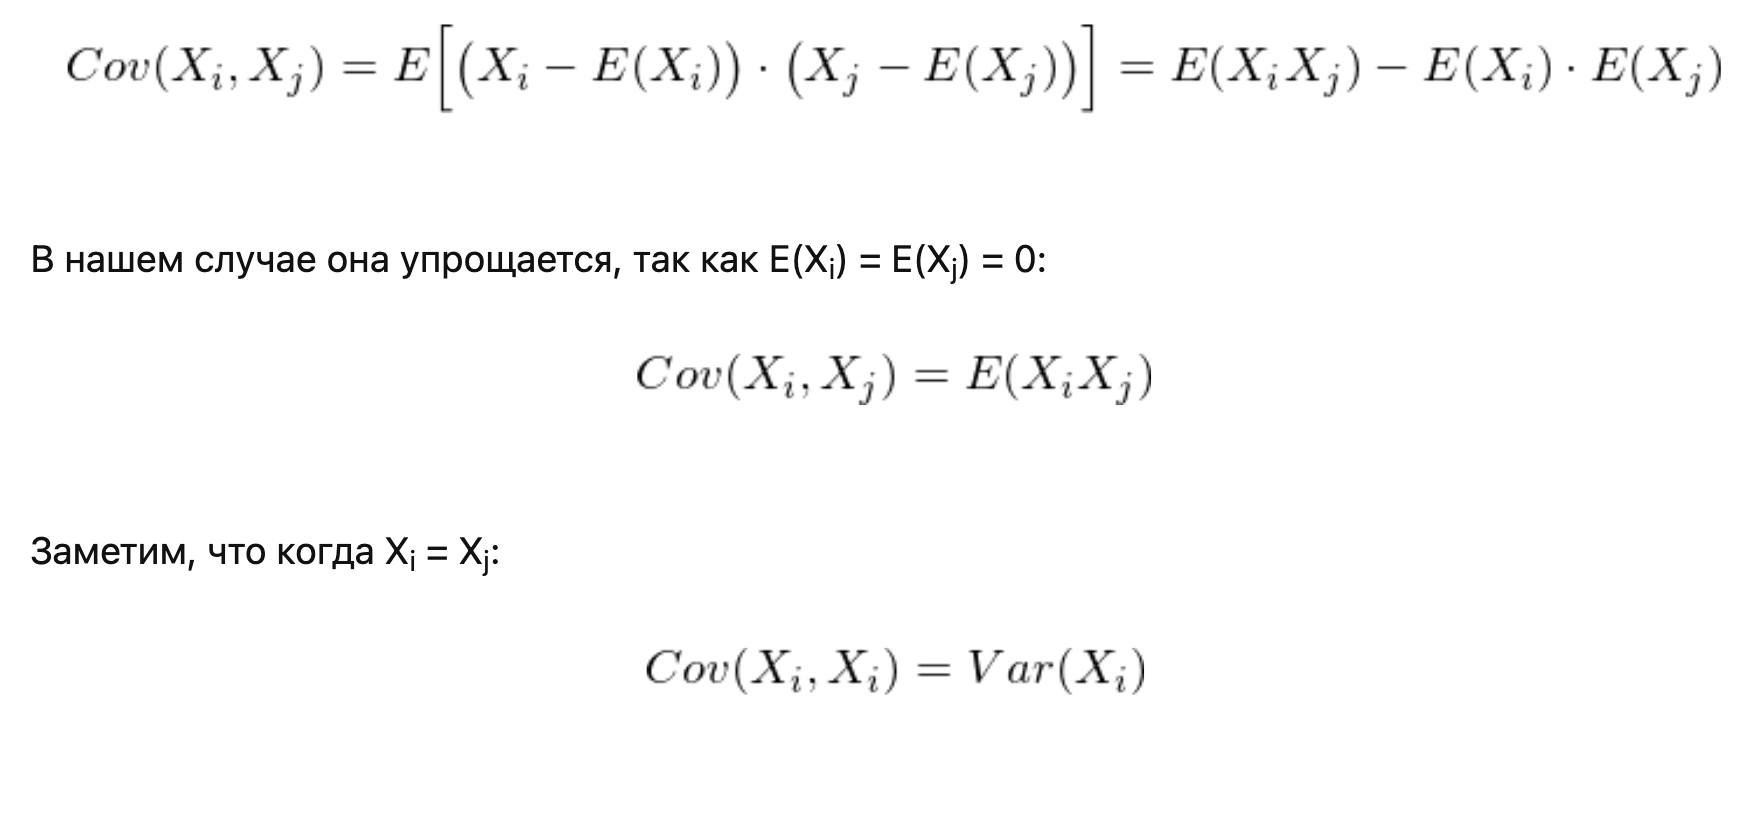

Если десперсия это sum((x - x_сред) * (x - x_сред)) / (len(x) - 1)

то для коварация нужен другой масив  sum((x - x_сред) * (y - y_сред)) / (len(x) - 1)


Теперь надо найти такой вектор , при котором максимизировался бы размер (дисперсия) проекции нашей выборки на него.

Направление максимальной дисперсии у проекции всегда совпадает с направлением собственного вектора, имеющим максимальное собственное значение, равное величине этой дисперсии.

почему это так, я не совсем понял, надеюсь, пойму потом

Определение: ненулевой вектор , который при умножении на некоторую квадратную матрицу  превращается в самого же себя с числовым коэффициентом , называется собственным вектором матрицы . Число  называют собственным значением или собственным числом данной матрицы.
(Вычислить его оказалось не так просто, так что возьмем готовую функцию np.linalg.eig) 
http://mathprofi.ru/sobstvennye_znachenija_i_sobstvennye_vektory.html

### Суть метода
Метод главных компоненнт строится по принцепу максимизации дисперции. Суть готорого найти компаненты, при проекции на которых мы бы сохранали большую часть информации, те где бы дисперсия была максимальна. Направление максимальной дисперсии совпадает с направлением собственного вектора матрицы коварации, которую мы получиди после оцентровки данных. После проецирования мы получаем компаненты, которые между собой не колерируют, но объясняют большую часть данных, те с максимальной дисперсией. Так как мы считаем, что чем больше дисперсия признака, тем больше он полезен при объяснении целевой переменной. Есть даже метод у pca, который показываез значимость компоненты, это просто сумма всех дисперсий признаков, деленная на диисперсию этого признака, просто доля, так что изи.


### Итоги pca

— во-первых, новые признаки — компоненты декоррелированны между собой; (Помогает при построение моделей)

— во-вторых, сумма дисперсий значений компонент равняется сумме дисперсий значений исходных признаков; (Если посчитать дисперсию по всем стобцам матрицы data_centre и сложить, то результат будет такой же, если эту операцию мы проведем на навых данных)

— в-третьих, на главной диагонали матрицы ковариации расположены дисперсии компонент в порядке убывания от большего к меньшему.

### Бонусы
1. Своя матрица коварации
2. Своя центрилизация
2. График
3. Поиск лучших компанент
4. востановление данных

In [77]:
class My_PCA:
    
    def __init__(self, n_components=2):
        self.n_components = n_components
        
    """Не всегда полученные главные компоненты будут иметь явный, понятный постороннему человеку, смысл. 
    Иногда полезно раскодировать, к примеру, обнаруженные выбросы, чтобы посмотреть, что за наблюдения за ними стоят."""
    def recovery_data(self):
        old_data = np.dot(self.data_proj, self.vec) + self.all_mean_data
        return old_data[:, :self.n_components]
    
    """Для начала необходиимо self.n_components указать под максимум, потом из спика best_pca понять нужно число дисперсий
    Возращает долю того, сколько дисперсии фича занимает от общей суммы дисперсии
    """
    def best_pca(self):
        all_var = sum(np.var(self.data_proj, axis=0))
        var_mas = []
        for i in range(len(self.data_proj[0])):
            var_mas.append(np.var(self.data_proj[:, i], axis=0) / all_var)
        return var_mas
            
    
    def projection(self, data_cov, data_centre):
        val, vec = np.linalg.eig(data_cov)  # находим собсвтенные значения и собственные вектора
        val, vec = val.real, vec.real
        idx = val.argsort()[::-1]
        l, principal_axes = val[idx], vec[:, idx]
        principal_components = np.dot(np.array(data_centre).T, principal_axes)
        U, s, Vt = la.svd(data_centre, full_matrices=False)
        V = Vt.T
        S = np.diag(s)
        return principal_components[:, :self.n_components]


    def covariance(self, mas1: list, mas2: list) -> int:
        return sum(mas1 * mas2) / (len(mas1) - 1)

    def matrix_covariance(self, data):
        matrix_covariance = []
        for i in data:
            mas = []
            for j in data:
                mas.append(self.covariance(i, j))
            matrix_covariance.append(mas)
        return matrix_covariance

    def despersi(self, mas):
        return sum((mas - mas.mean()) ** 2) / (len(mas) - 1)

    """центруем данные, те средние теперь равно 0"""
    """ возможно понадобится еще стандартизация"""

    def centre(self, data):
        self.all_mean_data = []
        self.centr_data = []
        for mas in data:
            mean = mas.mean()
            mas = (mas - mean)
            self.centr_data.append(mas)
            self.all_mean_data.append(mean)
        return self.centr_data

    """оригинальный pca и мы принимаем на вход таблицу, где колоник это фичи 
    """
    
    def transform(self, data):
        if self.n_components == -1:
            self.n_components = len(data[0])
        elif 0 >= self.n_components or self.n_components > len(data[0]):
            raise ValueError('n_components заданно не верно')

        data_centre = self.centre(data.T)
#         data_cov = self.matrix_covariance(data_centre) раньше я вычислял ее сам, но это оказалось очень медленно
        data_cov = np.cov(data_centre)
        self.data_proj = self.projection(data_cov, data_centre)
        return self.data_proj

    def fit(self, data=None, lab = None):
        pass

    def fit_transform(self, data, lab = None):
        self.fit(data)
        return self.transform(data)

In [3]:
# !pip install Cython

# качество снижается когда качество не то

### Тест 1

In [51]:
x = np.arange(1,11)
y = 2 * x + np.random.randn(10) * 2
z = 3 * x + np.random.randn(10) * 3
c = 4 * x + np.random.randn(10) * 3
X = np.vstack((x, y, z, c)).T

In [78]:
X

array([[ 1.        ,  1.28845348,  1.33402695,  1.05419276],
       [ 2.        ,  1.59068414,  7.8411852 ,  2.37370494],
       [ 3.        ,  6.78578558,  4.29559561, 13.57314377],
       [ 4.        ,  9.24580243,  4.62504042, 18.95927453],
       [ 5.        ,  8.11322265, 14.45349386, 21.05058494],
       [ 6.        , 12.88327396, 23.51550745, 22.19404101],
       [ 7.        , 12.21006164, 19.02383506, 31.26232241],
       [ 8.        , 15.59652375, 24.23081751, 31.71029792],
       [ 9.        , 15.31914439, 35.49051135, 34.41826501],
       [10.        , 22.11102833, 30.64350599, 40.13453944]])

In [79]:
my_pca = My_PCA(n_components=3)
data_my_pca = my_pca.fit_transform(X)
data_my_pca

array([[-27.5179438 ,  -2.08111464,  -0.56611275],
       [-22.35511573,  -6.3471421 ,  -0.05315445],
       [-14.80015767,   4.07539173,  -0.37134656],
       [ -9.85121478,   7.48986989,  -0.41515861],
       [ -2.60373043,   0.73973882,   1.85722039],
       [  5.50412739,  -4.63769747,  -1.66948959],
       [  9.01689027,   3.98891303,   2.45088003],
       [ 13.81699491,   0.92985926,  -0.25700321],
       [ 22.6575512 ,  -6.39800598,   1.54666832],
       [ 26.13259865,   2.24018745,  -2.52250357]])

In [76]:
pca = PCA(n_components=3)
data_pca = pca.fit_transform(X)
data_pca

array([[ 27.5179438 ,  -2.08111464,   0.56611275],
       [ 22.35511573,  -6.3471421 ,   0.05315445],
       [ 14.80015767,   4.07539173,   0.37134656],
       [  9.85121478,   7.48986989,   0.41515861],
       [  2.60373043,   0.73973882,  -1.85722039],
       [ -5.50412739,  -4.63769747,   1.66948959],
       [ -9.01689027,   3.98891303,  -2.45088003],
       [-13.81699491,   0.92985926,   0.25700321],
       [-22.6575512 ,  -6.39800598,  -1.54666832],
       [-26.13259865,   2.24018745,   2.52250357]])

In [8]:
len(data_pca), len(data_pca[0]), len(data_my_pca), len(data_my_pca[0])

(10, 4, 10, 4)

### Тест 2

In [80]:
data = mne.io.read_raw_edf('S001R01.edf', preload=True)
raw_data = data.get_data()
raw_data

Extracting EDF parameters from /Users/ila/Desktop/Python/my projects/total-perspective-vortex/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


array([[-1.6e-05, -5.6e-05, -5.5e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-2.9e-05, -5.4e-05, -5.5e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 2.0e-06, -2.7e-05, -2.9e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       ...,
       [-2.1e-05, -1.2e-05,  2.0e-06, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-1.1e-05,  1.0e-06,  1.8e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 1.5e-05,  2.1e-05,  3.5e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00]])

In [81]:
pca = PCA(n_components=15)
pca_raw_data = pca.fit_transform(raw_data.T)

In [82]:
raw_data.T.shape, pca_raw_data.shape

((9760, 64), (9760, 15))

In [83]:
my_pca = My_PCA(n_components=15)
my_pca_raw_data = my_pca.fit_transform(raw_data.T)

In [84]:
len(my_pca_raw_data), len(my_pca_raw_data[0])

(9760, 15)

In [85]:
my_pca_raw_data[1]

array([ 2.73974792e-04,  1.65052895e-05, -1.59232913e-05,  6.57606216e-05,
       -5.41328407e-05, -4.37249595e-05, -8.26428829e-06, -4.97035858e-05,
       -2.65886115e-06,  3.05587828e-05,  6.95574421e-06, -4.44041515e-06,
        2.88141044e-06,  1.07558288e-05, -3.48235470e-05])

In [86]:
pca_raw_data[1]

array([-2.73974792e-04,  1.65052895e-05,  1.59232907e-05, -6.57606189e-05,
        5.41328999e-05,  4.37247638e-05, -8.26393101e-06,  4.97048827e-05,
        2.66222036e-06, -3.05736989e-05,  7.00800279e-06, -4.44431420e-06,
        2.64605385e-06,  1.06013232e-05, -3.47501758e-05])

In [ ]:
# pip3 install --upgrade matplotlib

In [81]:
raw_data = raw_data[:3]

In [82]:
raw_data

array([[-1.6e-05, -5.6e-05, -5.5e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [-2.9e-05, -5.4e-05, -5.5e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00],
       [ 2.0e-06, -2.7e-05, -2.9e-05, ...,  0.0e+00,  0.0e+00,  0.0e+00]])

In [ ]:
# raw_data[0]

In [83]:
%%time
cen_data = my_pca.centre(raw_data)
cen_data

CPU times: user 462 µs, sys: 206 µs, total: 668 µs
Wall time: 502 µs


[array([-1.52395492e-05, -5.52395492e-05, -5.42395492e-05, ...,
         7.60450820e-07,  7.60450820e-07,  7.60450820e-07]),
 array([-3.10400615e-05, -5.60400615e-05, -5.70400615e-05, ...,
        -2.04006148e-06, -2.04006148e-06, -2.04006148e-06]),
 array([-7.97131148e-08, -2.90797131e-05, -3.10797131e-05, ...,
        -2.07971311e-06, -2.07971311e-06, -2.07971311e-06])]

In [63]:
%%time
cov_data = np.cov(cen_data)
cov_data

CPU times: user 6.91 ms, sys: 2.07 ms, total: 8.98 ms
Wall time: 7.45 ms


array([[3.31664145e-09, 3.09192626e-09, 2.90788284e-09, ...,
        1.52114568e-09, 1.30382525e-09, 1.25180825e-09],
       [3.09192626e-09, 3.19308611e-09, 3.07825103e-09, ...,
        1.65573640e-09, 1.54023445e-09, 1.40685832e-09],
       [2.90788284e-09, 3.07825103e-09, 3.21042566e-09, ...,
        1.59232179e-09, 1.49941764e-09, 1.32576826e-09],
       ...,
       [1.52114568e-09, 1.65573640e-09, 1.59232179e-09, ...,
        2.61822219e-09, 2.41905978e-09, 2.15948142e-09],
       [1.30382525e-09, 1.54023445e-09, 1.49941764e-09, ...,
        2.41905978e-09, 3.19176973e-09, 2.03725684e-09],
       [1.25180825e-09, 1.40685832e-09, 1.32576826e-09, ...,
        2.15948142e-09, 2.03725684e-09, 2.68449000e-09]])

In [64]:
%%time
proj_data = my_pca.projection(cov_data, cen_data)
proj_data

CPU times: user 7.22 ms, sys: 1.48 ms, total: 8.69 ms
Wall time: 4.01 ms


[array([ 2.47178301e-04,  2.73974792e-04,  2.52470047e-04, ...,
        -1.36574011e-05, -1.36574011e-05, -1.36574011e-05]),
 array([ 3.43105471e-05,  1.65052895e-05, -5.05000614e-05, ...,
         1.37922625e-05,  1.37922625e-05,  1.37922625e-05])]

In [ ]:
3

In [ ]:
# val, vec = np.linalg.eig(cov_data) 

In [ ]:
len(cov_data), len(cov_data[0])